# Setup & Imports


In [1]:
from pathlib import Path
import json
import random
import numpy as np
import pandas as pd
from scipy.io import arff
import matplotlib.pyplot as plt
import joblib

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

random.seed(42)
np.random.seed(42)


# Config


In [2]:
DATA_PATH = Path('data') / 'dataset.arff'
TARGET_COL = 'price'
DROP_COLS = ['id']
CATEGORICAL_FEATURES = ['zipcode']
NUMERIC_FEATURES = [
    'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
    'waterfront', 'view', 'condition', 'grade', 'sqft_above',
    'sqft_basement', 'yr_built', 'yr_renovated', 'lat', 'long',
    'sqft_living15', 'sqft_lot15', 'date_year', 'date_month', 'date_day',
]
RANDOM_STATE = 42
REPORTS_DIR = Path('reports')
REPORTS_DIR.mkdir(parents=True, exist_ok=True)


# Load Data


In [3]:
data, meta = arff.loadarff(DATA_PATH)
df = pd.DataFrame(data)

if 'zipcode' in df.columns:
    df['zipcode'] = df['zipcode'].apply(lambda x: x.decode('utf-8') if isinstance(x, (bytes, bytearray)) else str(x))

missing_cols = set(NUMERIC_FEATURES + CATEGORICAL_FEATURES + [TARGET_COL]) - set(df.columns)
if missing_cols:
    raise ValueError(f'Missing expected columns: {sorted(missing_cols)}')


# Train/Test Split


In [4]:
y = pd.to_numeric(df[TARGET_COL], errors='coerce')
df = df.loc[y.notna()].copy()
y = y.loc[y.notna()]
X = df.drop(columns=[TARGET_COL] + DROP_COLS)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE
)


# Preprocessing (ColumnTransformer)


In [5]:
def build_preprocessor():
    numeric_pipeline = Pipeline(
        steps=[
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler()),
        ]
    )

    categorical_pipeline = Pipeline(
        steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False)),
        ]
    )

    return ColumnTransformer(
        transformers=[
            ('num', numeric_pipeline, NUMERIC_FEATURES),
            ('cat', categorical_pipeline, CATEGORICAL_FEATURES),
        ]
    )


# Model definitions + param grids


In [ ]:
models = {
    'Ridge': Ridge(),
    'DecisionTree': DecisionTreeRegressor(random_state=RANDOM_STATE),
    'RandomForest': RandomForestRegressor(random_state=RANDOM_STATE, n_jobs=-1),
}

param_grids = {
    'Ridge': {
        'model__alpha': np.logspace(-3, 3, 50),
    },
    'DecisionTree': {
        'model__max_depth': [None, 5, 10, 20, 30, 50],
        'model__min_samples_split': [2, 5, 10, 20, 50],
        'model__min_samples_leaf': [1, 2, 5, 10, 20],
        'model__max_features': [None, 'sqrt', 'log2'],
        'model__criterion': ['squared_error', 'friedman_mse'],
    },
    'RandomForest': {
        'model__n_estimators': [200, 400, 600, 800],
        'model__max_depth': [None, 5, 10, 20, 30, 50],
        'model__min_samples_split': [2, 5, 10, 20],
        'model__min_samples_leaf': [1, 2, 4, 8],
        'model__max_features': ['sqrt', 'log2', None],
        'model__bootstrap': [True, False],
    },
}

try:
    from xgboost import XGBRegressor
    models['XGBoost'] = XGBRegressor(
        objective='reg:squarederror',
        random_state=RANDOM_STATE,
        n_jobs=-1,
        tree_method='hist',
    )
    param_grids['XGBoost'] = {
        'model__n_estimators': [300, 600, 900, 1200],
        'model__learning_rate': [0.01, 0.03, 0.05, 0.1, 0.2],
        'model__max_depth': [3, 4, 5, 6, 8, 10],
        'model__min_child_weight': [1, 3, 5, 10],
        'model__subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
        'model__colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
        'model__gamma': [0, 0.05, 0.1, 0.2, 0.5],
        'model__reg_alpha': [0, 0.01, 0.1, 1.0, 10.0],
        'model__reg_lambda': [0.5, 1.0, 2.0, 5.0, 10.0],
    }
except Exception as exc:
    print(f'XGBoost unavailable, skipping. Reason: {exc}')


# Training + tuning function


In [10]:
def run_random_search(model, param_grid, X_train, y_train):
    preprocessor = build_preprocessor()
    pipe = Pipeline(
        steps=[
            ('preprocess', preprocessor),
            ('model', model),
        ]
    )
    search = RandomizedSearchCV(
        estimator=pipe,
        param_distributions=param_grid,
        n_iter=20,
        cv=5,
        scoring='neg_root_mean_squared_error',
        random_state=RANDOM_STATE,
        n_jobs=-1,
    )
    search.fit(X_train, y_train)
    return search


def evaluate_model(model, X_test, y_test):
    preds = model.predict(X_test)

    mse = mean_squared_error(y_test, preds)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, preds)
    r2 = r2_score(y_test, preds)

    return rmse, mae, r2, preds


# Run experiments + results table


In [11]:
results = []
best_estimators = {}

for name, model in models.items():
    print(f'Training {name}...')
    search = run_random_search(model, param_grids[name], X_train, y_train)
    best_model = search.best_estimator_
    rmse, mae, r2, _ = evaluate_model(best_model, X_test, y_test)
    best_estimators[name] = best_model
    results.append({
        'model': name,
        'best_params': search.best_params_,
        'rmse': rmse,
        'mae': mae,
        'r2': r2,
    })

results_df = pd.DataFrame(results).sort_values(by='rmse', ascending=True)
results_df.to_csv(REPORTS_DIR / 'metrics.csv', index=False)
results_df


Training Ridge...
Training DecisionTree...
Training RandomForest...
Training XGBoost...


,model,best_params,rmse,mae,r2
3,XGBoost,"{'model__subsample': 0.8, 'model__reg_lambda':...",133549.101972,66725.997600,0.882023
2,RandomForest,"{'model__n_estimators': 600, 'model__min_sampl...",146514.645343,72092.241595,0.858004
0,Ridge,{'model__alpha': 0.1206792640639329},170321.617442,98300.540978,0.808109
1,DecisionTree,"{'model__min_samples_split': 20, 'model__min_s...",182775.760152,94816.334838,0.779020


# Pick best model + plots


Best model: XGBoost
RMSE: 133,549.10  MAE: 66,726.00  R2: 0.882


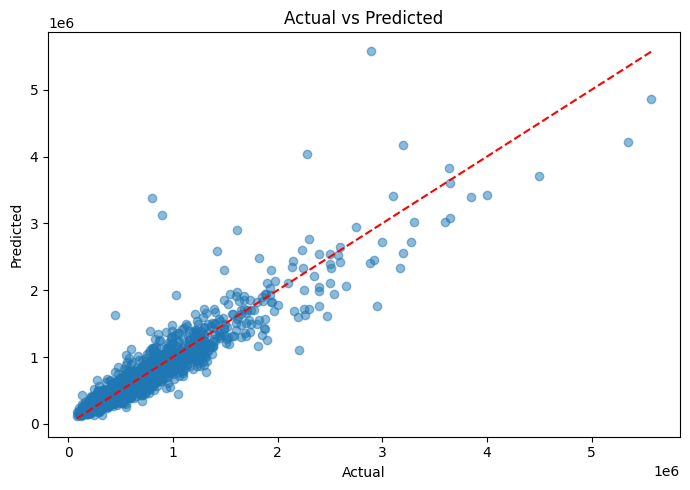

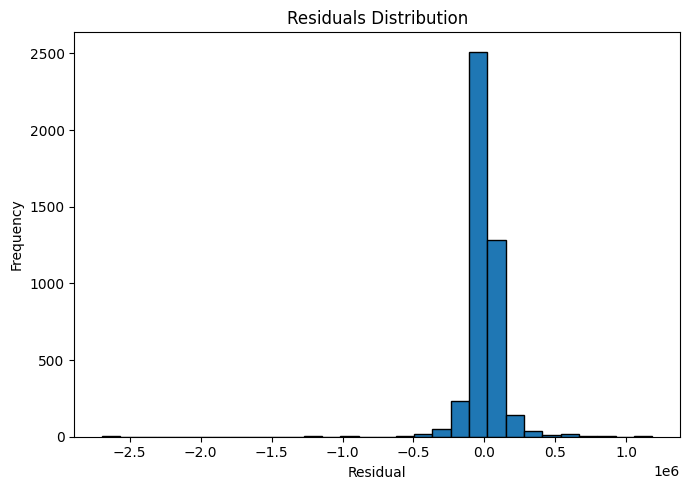

In [12]:
best_row = results_df.iloc[0]
best_name = best_row['model']
best_model = best_estimators[best_name]

rmse, mae, r2, preds = evaluate_model(best_model, X_test, y_test)

best_params_path = REPORTS_DIR / 'best_params.json'
with best_params_path.open('w', encoding='utf-8') as f:
    json.dump(best_row['best_params'], f, indent=2, default=str)

print(f'Best model: {best_name}')
print(f'RMSE: {rmse:,.2f}  MAE: {mae:,.2f}  R2: {r2:.3f}')

actual_vs_predicted_path = REPORTS_DIR / 'actual_vs_predicted.png'
plt.figure(figsize=(7, 5))
plt.scatter(y_test, preds, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted')
plt.tight_layout()
plt.savefig(actual_vs_predicted_path, dpi=150)
plt.show()

residuals = y_test - preds
residuals_path = REPORTS_DIR / 'residuals.png'
plt.figure(figsize=(7, 5))
plt.hist(residuals, bins=30, edgecolor='black')
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.title('Residuals Distribution')
plt.tight_layout()
plt.savefig(residuals_path, dpi=150)
plt.show()


# Save model


In [13]:
model_dir = Path('models')
model_dir.mkdir(parents=True, exist_ok=True)
model_path = model_dir / 'best_model.joblib'
joblib.dump(best_model, model_path)
print(f'Saved best model to {model_path}')


Saved best model to models\best_model.joblib
